# Introduction to the Gaussian process regression 
## Solusion to the Practice ploblem


Course
- SURF 2016

Lecturer :
- Georgios Karagiannis, Department of Mathematics, Purdue

July 8, 2016

Objective :

- We wish to build a Gaussian Process regression --a probabilistic surrogate model-- in order to be able to emulate the output of the Piston Simulator, with respect to specified inputs.

Related material:

    Readings :
    
    - Rasmussen, Carl Edward. "Gaussian processes in machine learning." In Advanced lectures on machine learning, pp. 63-71. Springer Berlin Heidelberg, 2004. 	
        - see http://www.GaussianProcess.org/gpml
        - Chapters: 2, 4, 5.1, & 5.4.2

    - Slides provided
    
    Software :
    
    - R-cran (https://cran.r-project.org/)
    - R packages 
        - DiceKrigin (https://cran.r-project.org/web/packages/DiceKriging/index.html)
        - lhs (https://cran.r-project.org/web/packages/lhs/index.html)
    - Roustant, Olivier, David Ginsbourger, and Yves Deville. "DiceKriging, DiceOptim: Two R packages for the analysis of computer experiments by kriging-based metamodeling and optimization." (2012).
        - Plus dependences ...

# The Piston Simulation function model

The Piston Simulation function models the circular motion of a piston within a cylinder. It involves a chain of nonlinear functions. 

The response C is cycle time (the time it takes to complete one cycle), in seconds. 

$$
C(x) = 2\pi \sqrt{\frac{M}{k+S^2}\frac{P_0 V_0}{T_0}\frac{T_0}{V^2}}
$$

$$
V = \frac{S}{2k} ( \sqrt{A^2 +4k\frac{P_0 V_0}{T_0}T_a} -A)
$$

$$
A = P_0 S 19.62M-\frac{kV_0}{S}
$$

The input variables and their usual input ranges are: 
<pre>

--------------------------------------------------
M  ∈ [30, 60]        | piston weight (kg)
S  ∈ [0.005, 0.020]  | piston surface area (m2)
V0 ∈ [0.002, 0.010]  | initial gas volume (m3)
k  ∈ [1000, 5000]    | spring coefficient (N/m)
P0 ∈ [90000, 110000] | atmospheric pressure (N/m2)
Ta ∈ [290, 296]      | ambient temperature (K)
T0 ∈ [340, 360]      | filling gas temperature (K)
--------------------------------------------------

</pre>

Here, we consider the output in the log scale.

=> As a result we wish to emulate the function f(M, S, V0 k, P0, Ta, T0) := log(C(M, S, V0 k, P0, Ta, T0)).

Reference:
http://www.sfu.ca/~ssurjano/piston.html

Kenett, R., & Zacks, S. (1998). Modern industrial statistics: design and control of quality and reliability. Pacific Grove, CA: Duxbury press.




## Software preparation

In [1]:
# DOWNLOAD THE R PACKAGES REQUIRED
install.packages('DiceKriging', repos = "http://cran.us.r-project.org")
install.packages('lhs', repos = "http://cran.us.r-project.org")
# install.packages('tcltk', repos = "http://cran.us.r-project.org")
# install.packages('aplpack', repos = "http://cran.us.r-project.org")

Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("DiceKriging", repos = "http://cran.us.r-project.org"): installation of package ‘DiceKriging’ had non-zero exit statusInstalling package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("lhs", repos = "http://cran.us.r-project.org"): installation of package ‘lhs’ had non-zero exit status

In [2]:
# LOAD THE R PACKAGES REQUIRED
library('lhs')
library('DiceKriging')
# library('tcltk')
# library('aplpack')

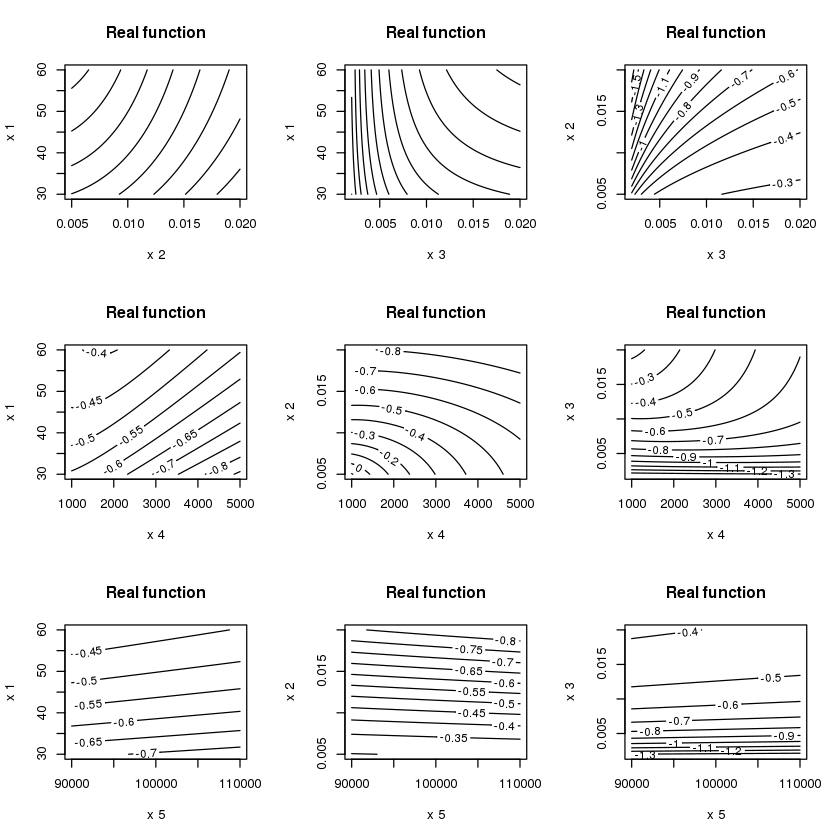

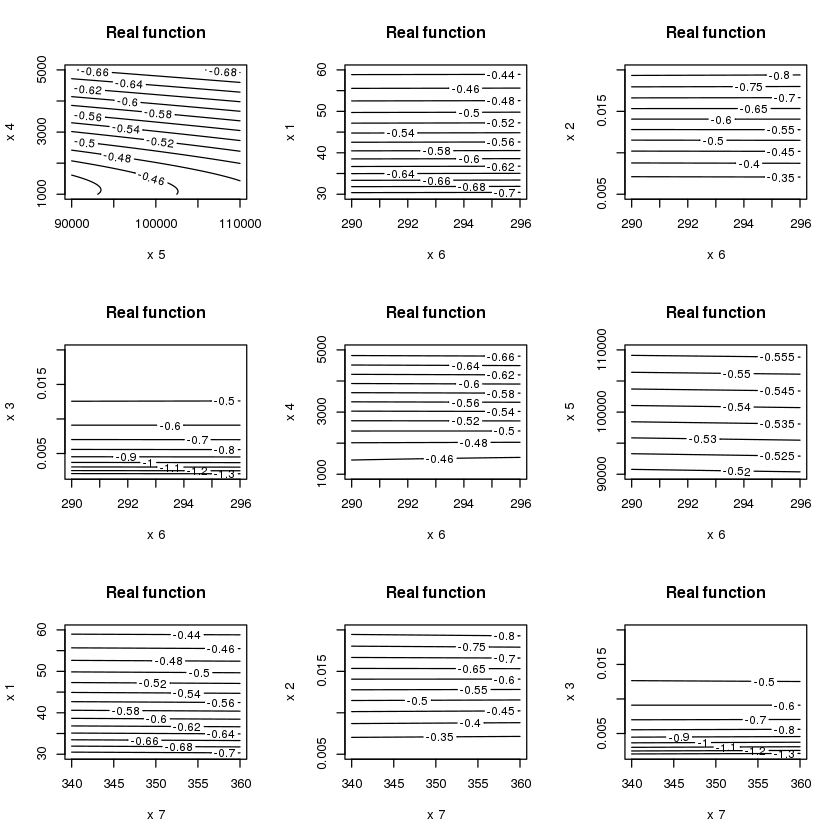

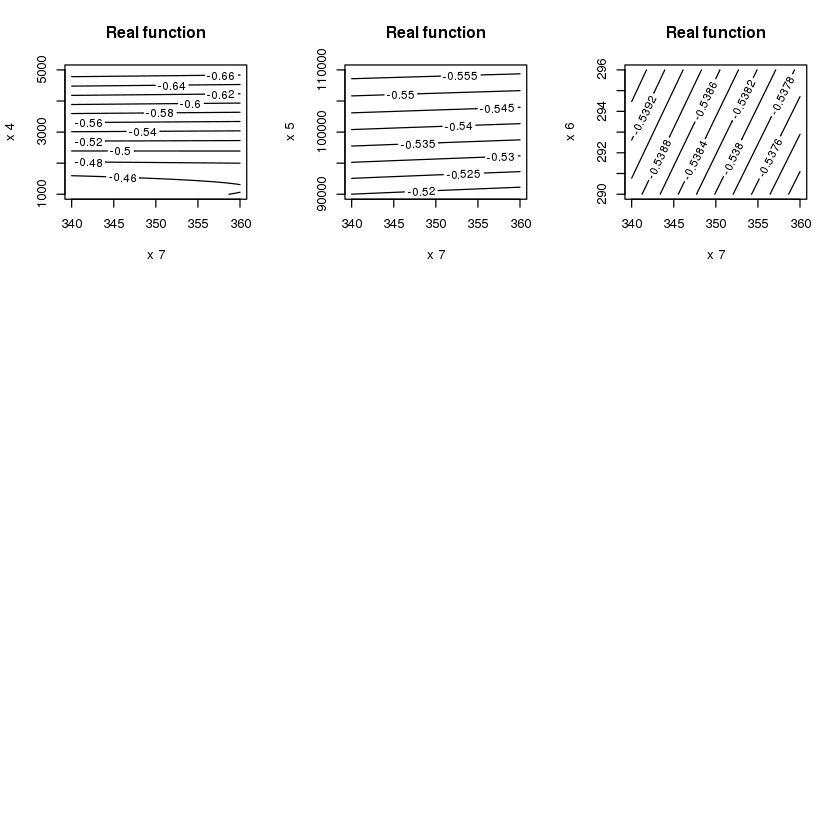

In [3]:
# THIS IS THE SIMULATOR AND THE MIN AND MAX OF THE INPUTS

piston <- function(xx) {
  ##########################################################################
  #
  # PISTON FUNCTION
  #
  # Authors: Sonja Surjanovic, Simon Fraser University
  #          Derek Bingham, Simon Fraser University
  # Questions/Comments: Please email Derek Bingham at dbingham@stat.sfu.ca.
  #
  # Copyright 2013. Derek Bingham, Simon Fraser University.
  #
  # THERE IS NO WARRANTY, EXPRESS OR IMPLIED. WE DO NOT ASSUME ANY LIABILITY
  # FOR THE USE OF THIS SOFTWARE.  If software is modified to produce
  # derivative works, such modified software should be clearly marked.
  # Additionally, this program is free software; you can redistribute it 
  # and/or modify it under the terms of the GNU General Public License as 
  # published by the Free Software Foundation; version 2.0 of the License. 
  # Accordingly, this program is distributed in the hope that it will be 
  # useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
  # of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
  # General Public License for more details.
  #
  # For function details and reference information, see:
  # http://www.sfu.ca/~ssurjano/
  #
  ##########################################################################
  #
  # OUTPUT AND INPUT:
  #
  # C = cycle time
  # xx = c(M, S, V0, k, P0, Ta, T0)
  #
  ##########################################################################
  
  M  <- xx[1]
  S  <- xx[2]
  V0 <- xx[3]
  k  <- xx[4]
  P0 <- xx[5]
  Ta <- xx[6]
  T0 <- xx[7]
  
  Aterm1 <- P0 * S
  Aterm2 <- 19.62 * M
  Aterm3 <- -k*V0 / S
  A <- Aterm1 + Aterm2 + Aterm3
  
  Vfact1 <- S / (2*k)
  Vfact2 <- sqrt(A^2 + 4*k*(P0*V0/T0)*Ta)
  V <- Vfact1 * (Vfact2 - A)
  
  fact1 <- M
  fact2 <- k + (S^2)*(P0*V0/T0)*(Ta/(V^2))
  
  C <- 2 * pi * sqrt(fact1/fact2)
  return(C)
}
input_min <- c(30, 0.005, 0.002, 1000, 90000, 290, 340 )
input_max <- c(60, 0.020, 0.020, 5000, 110000, 296, 360 )
input_d <- length(input_min)

myfun <- function(xx) {return(log(piston(xx))) }

# PLOT THE REAL FUNCTION TO SEE HOW IT LOOKS LIKE

par(mfrow = c(3,3))
for (i in 1:input_d) {
    for ( j in 1:input_d ) 
        if(i>j) {
        n.grid <- 100 ;
        x1.grid <-seq(input_min[i],input_max[i],length.out=n.grid) ;
        x2.grid <-seq(input_min[j],input_max[j],length.out=n.grid) ;
        X.grid <- expand.grid( x1=x1.grid,  x2=x2.grid )
        myfun2d<-function(xx){ 
                            zz<-0.5*(input_min+input_max) ; 
                            zz[i]<-xx[1]; zz[j]<-xx[2]; 
                            return(myfun(zz)) 
                    }
        y.grid <- apply(X.grid,1,myfun2d)
    contour(x1.grid, x2.grid, matrix(y.grid, n.grid, n.grid), 10, 
            main = "Real function", 
            xlab = paste("x", as.character(i)), 
            ylab = paste("x", as.character(j)),
            xlim = c(input_min[i],input_max[i]), 
            ylim = c(input_min[j],input_max[j]))
    }
}

## Generate a training data-set

Generate a training data-set $D={(x_i,y_i);i=1,...,n}$  of size $n=20$ via a LHS.

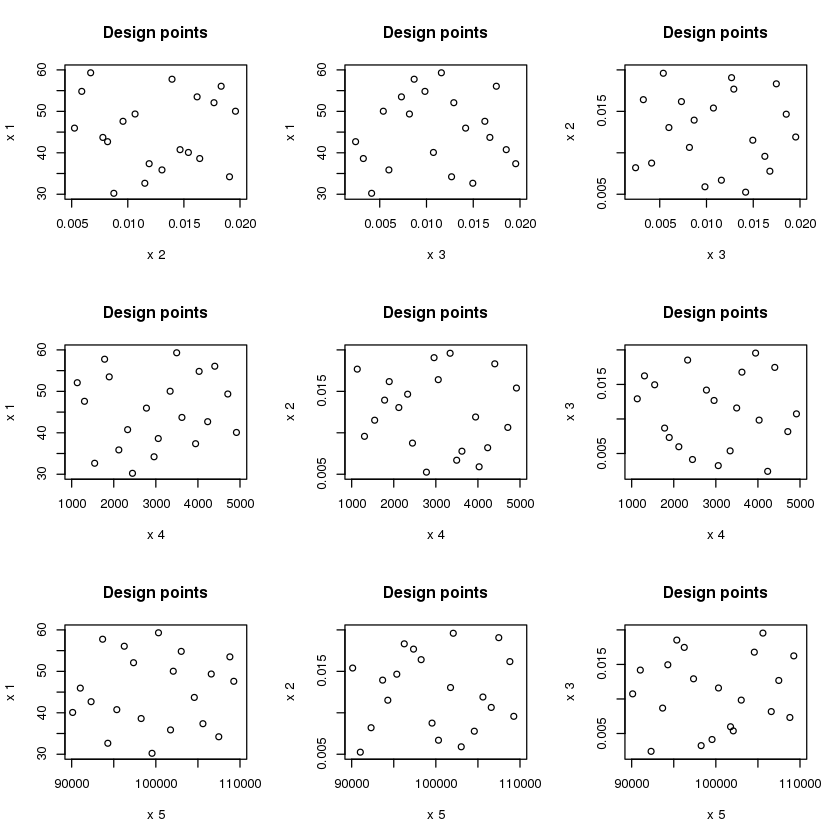

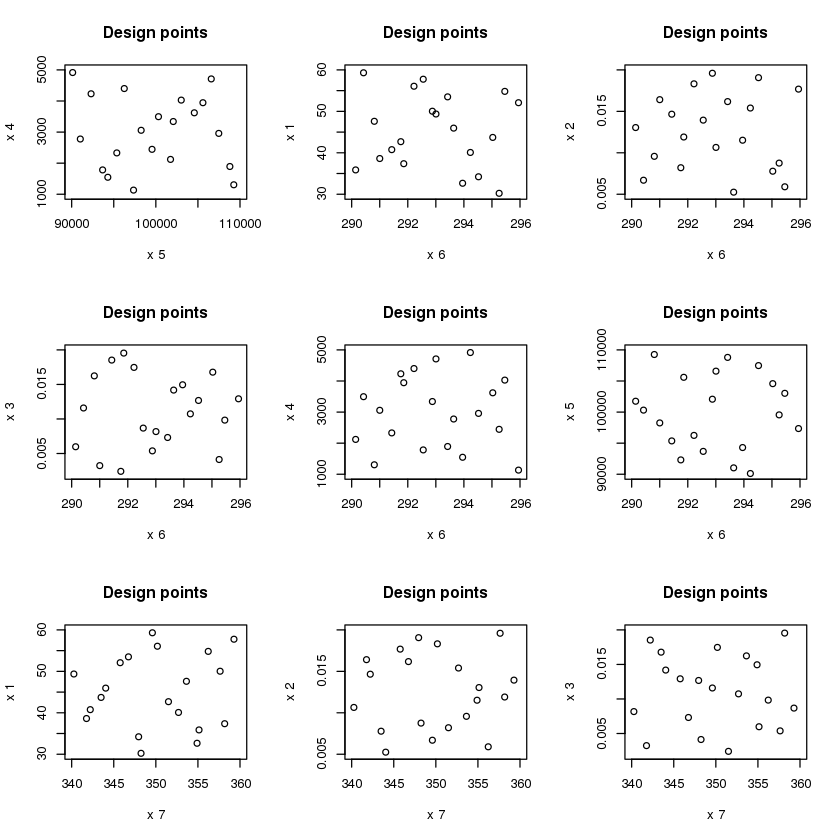

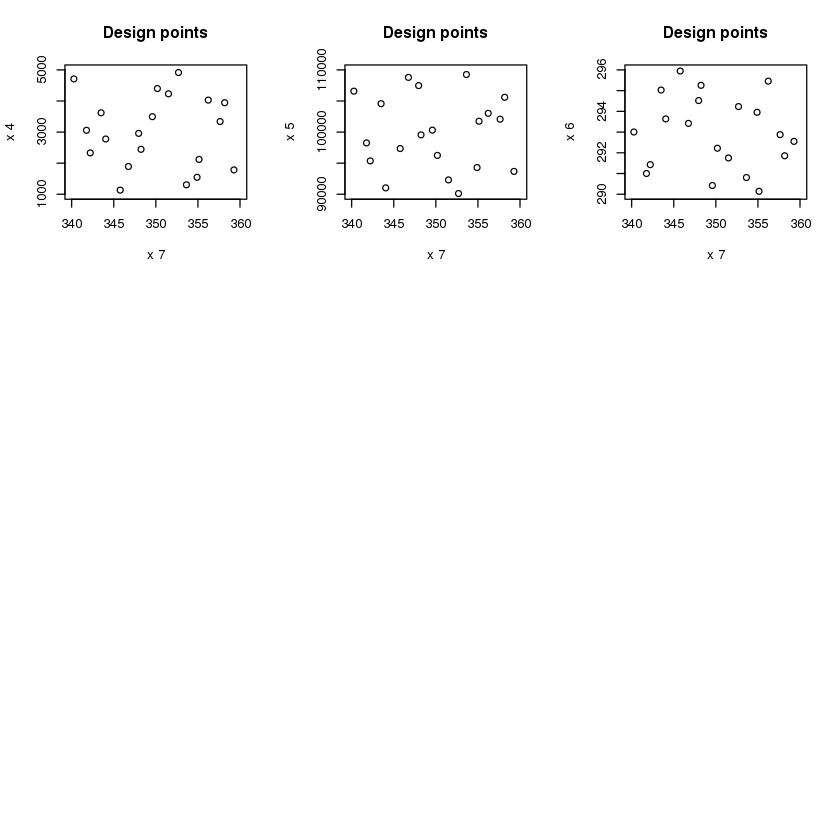

In [4]:
# GENERATE THE TRAINING DATA SET
n_data <- 20 ;
n_dim <- length(input_min)
X_data <- t(input_min + (input_max-input_min)*t(optimumLHS(n=n_data, k=n_dim))) ;
Y_data <- apply(X_data, 1, myfun) ;

# PLOT THE INPUT POINT TO SEE THE SPREAD
par(mfrow = c(3,3))
for (i in 1:n_dim) 
    for ( j in 1:n_dim ) 
        if(i>j) {
            plot(X_data[,i], X_data[,j], 
                main = "Design points", 
                xlab = paste("x", as.character(i)), 
                ylab = paste("x", as.character(j)) ,
                xlim = c(input_min[i],input_max[i]), 
                ylim = c(input_min[j],input_max[j])
                    )
            }

# Have a look to the functions again

In [10]:
# We use the function:
#  km {DiceKriging}
?km

km                 package:DiceKriging                 R Documentation

_F_i_t _a_n_d/_o_r _c_r_e_a_t_e _k_r_i_g_i_n_g _m_o_d_e_l_s

_D_e_s_c_r_i_p_t_i_o_n:

     ‘km’ is used to fit kriging models when parameters are unknown, or
     to create ‘km’ objects otherwise. In both cases, the result is a
     ‘km’ object. If parameters are unknown, they are estimated by
     Maximum Likelihood. As a beta version, Penalized Maximum
     Likelihood Estimation is also possible if some penalty is given,
     or Leave-One-Out for noise-free observations.

_U_s_a_g_e:

     km(formula=~1, design, response, covtype="matern5_2",
        coef.trend = NULL, coef.cov = NULL, coef.var = NULL,
        nugget = NULL, nugget.estim=FALSE, noise.var=NULL, estim.method="MLE",
        penalty = NULL, optim.method = "BFGS", lower = NULL, upper = NULL, 
        parinit = NULL, multistart = 1, control = NULL, gr = TRUE, 
        iso=FALSE, scaling=FALSE, knots=NULL, kernel=NULL)
     
_A_r_g_u_m_e_n_t_s:

 formula: an optional object of class "formula" specifying the linear
          trend of the kriging model (see ‘lm’). This formula should
          concern only the input variables, and not the output
          (response). If there is any, it is automatically dropped. In
          particular, no response transformation is available yet. The
          default is ‘~1’, which defines a constant trend.

  design: a data frame representing the design of experiments. The ith
          row contains the values of the d input variables
          corresponding to the ith evaluation

response: a vector (or 1-column matrix or data frame) containing the
          values of the 1-dimensional output given by the objective
          function at the ‘design’ points.

 covtype: an optional character string specifying the covariance
          structure to be used, to be chosen between ‘"gauss"’,
          ‘"matern5_2"’, ‘"matern3_2"’, ‘"exp"’ or ‘"powexp"’. See a
          full description of available covariance kernels in
          ‘covTensorProduct-class’. Default is ‘"matern5_2"’. See also
          the argument ‘kernel’ that allows the user to build its own
          covariance structure.

coef.trend,: (see below)

coef.cov,: (see below)

coef.var: optional vectors containing the values for the trend,
          covariance and variance parameters. For estimation, 4 cases
          are implemented: 1. (All unknown) If all are missing, all are
          estimated. 2. (All known) If all are provided, no estimation
          is performed; 3. (Known trend) If ‘coef.trend’ is provided
          but at least one of ‘coef.cov’ or ‘coef.var’ is missing, then
          BOTH ‘coef.cov’ and ‘coef.var’ are estimated; 4. (Unknown
          trend) If ‘coef.cov’ and ‘coef.var’ are provided but
          ‘coef.trend’ is missing, then ‘coef.trend’ is estimated (GLS
          formula).

  nugget: an optional variance value standing for the homogeneous
          nugget effect.

nugget.estim: an optional boolean indicating whether the nugget effect
          should be estimated. Note that this option does not concern
          the case of heterogeneous noisy observations (see ‘noise.var’
          below). If ‘nugget’ is given, it is used as an initial value.
          Default is ‘FALSE’.

noise.var: for noisy observations : an optional vector containing the
          noise variance at each observation. This is useful for
          stochastic simulators. Default is ‘NULL’.

estim.method: a character string specifying the method by which unknown
          parameters are estimated. Default is ‘"MLE"’ (Maximum
          Likelihood). At this stage, a beta version of leave-One-Out
          estimation (‘estim.method="LOO"’) is also implemented for
          noise-free observations.

 penalty: (beta version) an optional list suitable for Penalized
          Maximum Likelihood Estimation. The list must contain the item
          ‘fun’ indicatin

## Compare different GP regression models

Use the diagnostics we leant, and compare Gaussian process regression models deffering on the prior linear trend structure or the covariance function

In [116]:
# Diagnostics (Feel free to use others that you know)

R2 <-function (Y, Ypred) {
    Ypred <- as.numeric(Ypred)
    Y <- as.numeric(Y)
    return(1 - mean((Y - Ypred)^2)/mean((Y - mean(Y))^2))
}

RMSE <- function (Y, Ypred)  {
    Ypred <- as.numeric(Ypred)
    Y <- as.numeric(Y)
    return(sqrt(mean((Y - Ypred)^2)))
}

MAE <- function (Y, Ypred)  {
    Ypred <- as.numeric(Ypred) 
    Y <- as.numeric(Y)
    return(mean(abs(Y - Ypred)))
}

In [117]:
# Train different GP regressions differing on the covariance function

myfun_km_matern5_2 <- km( formula = ~ 1 , # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2], 
                                    x3=X_data[,3], 
                                    x4=X_data[,4], 
                                    x5=X_data[,5], 
                                    x6=X_data[,6], 
                                    x7=X_data[,7]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="matern5_2",                # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)                        # a user's new covariance structure

myfun_km_matern3_2  <- km( formula = ~ 1 , # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2], 
                                    x3=X_data[,3], 
                                    x4=X_data[,4], 
                                    x5=X_data[,5], 
                                    x6=X_data[,6], 
                                    x7=X_data[,7]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="matern3_2",                # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)  

myfun_km_gauss <- km( formula = ~ 1 ,        # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2], 
                                    x3=X_data[,3], 
                                    x4=X_data[,4], 
                                    x5=X_data[,5], 
                                    x6=X_data[,6], 
                                    x7=X_data[,7]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="gauss",                    # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)                        # a user's new covariance structure

myfun_km_exp <- km( formula = ~ 1 , # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2], 
                                    x3=X_data[,3], 
                                    x4=X_data[,4], 
                                    x5=X_data[,5], 
                                    x6=X_data[,6], 
                                    x7=X_data[,7]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="exp",                      # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)                        # a user's new covariance structure

# CROSS VALIDATION CRITERIA
Y_pred <- leaveOneOut.km(myfun_km_matern5_2, "UK")$mean
CV_matern5_2 <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="matern5_2")


Y_pred <- leaveOneOut.km(myfun_km_matern3_2, "UK")$mean
CV_matern3_2 <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="matern3_2")

Y_pred <- leaveOneOut.km(myfun_km_gauss, "UK")$mean
CV_gauss <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="gauss~~~~")

Y_pred <- leaveOneOut.km(myfun_km_exp, "UK")$mean
CV_exp <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="exp~~~~~~")


# PRINT THE RESULTS TO COMPARE

CV_matern5_2
CV_matern3_2
CV_gauss
CV_exp

R2      RMSE        MAE
matern5_2 0.8599971 0.1155351 0.08513416

R2      RMSE        MAE
matern3_2 0.8809931 0.1065201 0.07850884

R2      RMSE        MAE
gauss~~~~ 0.8945756 0.1002573 0.07906424

R2      RMSE       MAE
exp~~~~~~ 0.5998559 0.1953232 0.1518888

## Choose the 'Best' model

In [118]:
# SELECT THE BEST GAUSSIAN PROCESS

myfun_km <- myfun_km_gauss

## Check the validity of the chossen 'Best' model

R2      RMSE        MAE
1 0.8945756 0.1002573 0.07906424

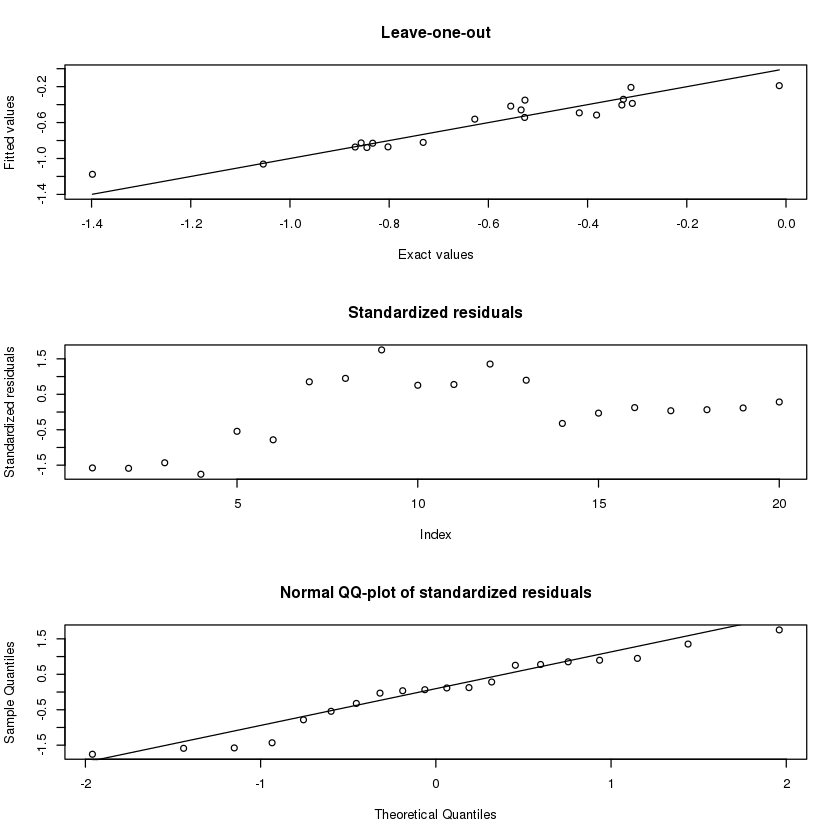

In [119]:
# CROSS VALIDATION CRITERIA
Y_pred <- leaveOneOut.km(myfun_km, "UK")$mean
data.frame(
    R2 = R2(Y_data, Y_pred),
    RMSE = RMSE(Y_data, Y_pred),
    MAE = MAE(Y_data, Y_pred))

# PLOT DIAGNOSTICS
plot(myfun_km)

## Print the estimates of the hyperparameters

In [120]:
# PRINT THE PARAMETERS

show(myfun_km)


Call:
km(formula = ~1, design = data.frame(x1 = X_data[, 1], x2 = X_data[, 
    2], x3 = X_data[, 3], x4 = X_data[, 4], x5 = X_data[, 5], 
    x6 = X_data[, 6], x7 = X_data[, 7]), response = Y_data, covtype = "gauss", 
    coef.trend = NULL, coef.cov = NULL, coef.var = NULL, nugget = 1e-07, 
    noise.var = NULL, optim.method = "BFGS", lower = NULL, upper = NULL, 
    control = list(trace = FALSE), kernel = NULL)

Trend  coeff.:
               Estimate
 (Intercept)    -0.7066

Covar. type  : gauss 
Covar. coeff.:
               Estimate 
   theta(x1)    37.9296 
   theta(x2)     0.0134 
   theta(x3)     0.0109 
   theta(x4)  7517.9779 
   theta(x5)  32294.7850
   theta(x6)    10.8707 
   theta(x7)    39.9245 

Variance estimate: 0.1318864

Nugget effect : 1e-07



## Plot the posterior GPR mean and variance, as well as the real function (in contour plots)

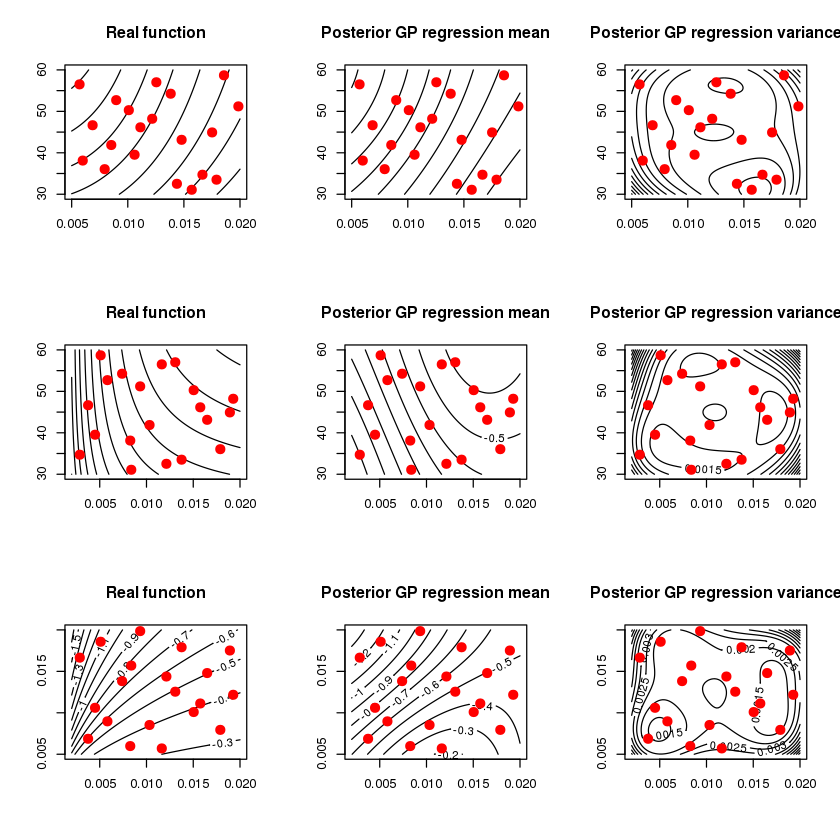

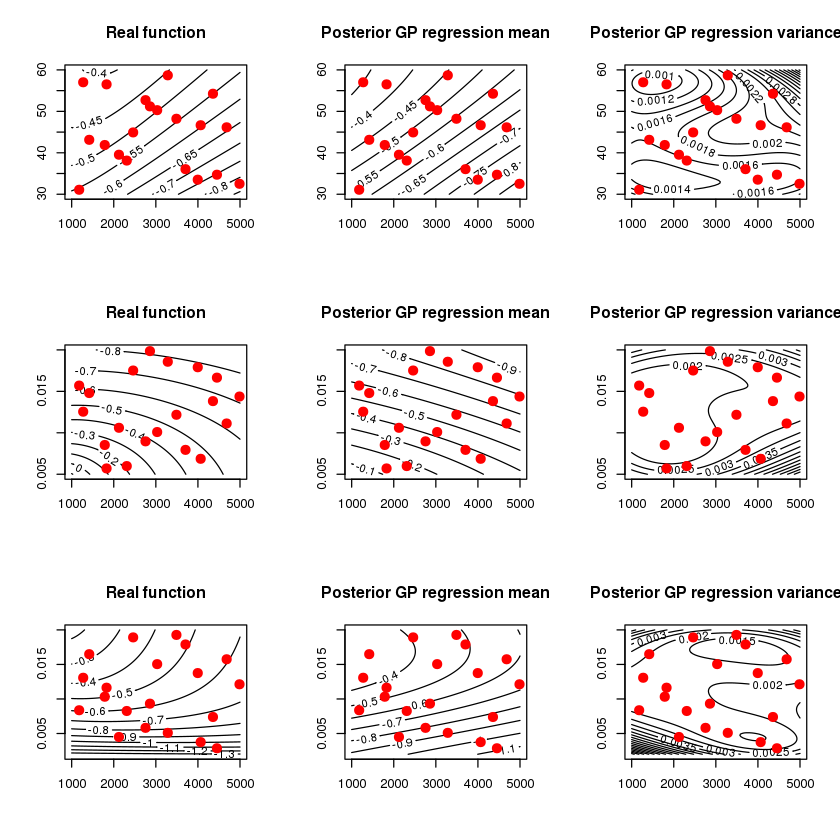

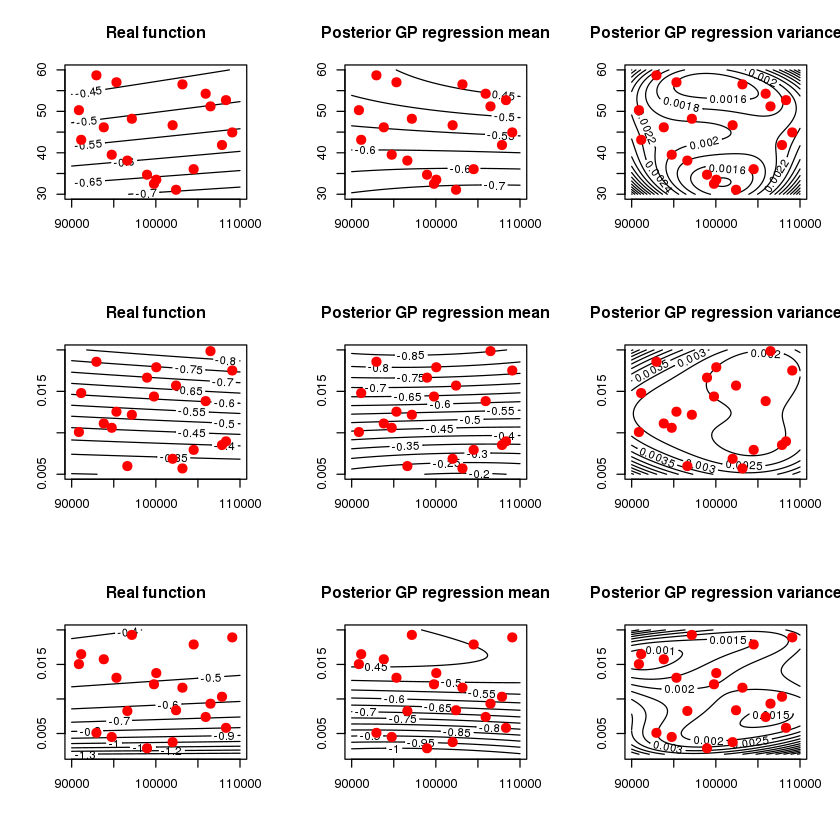

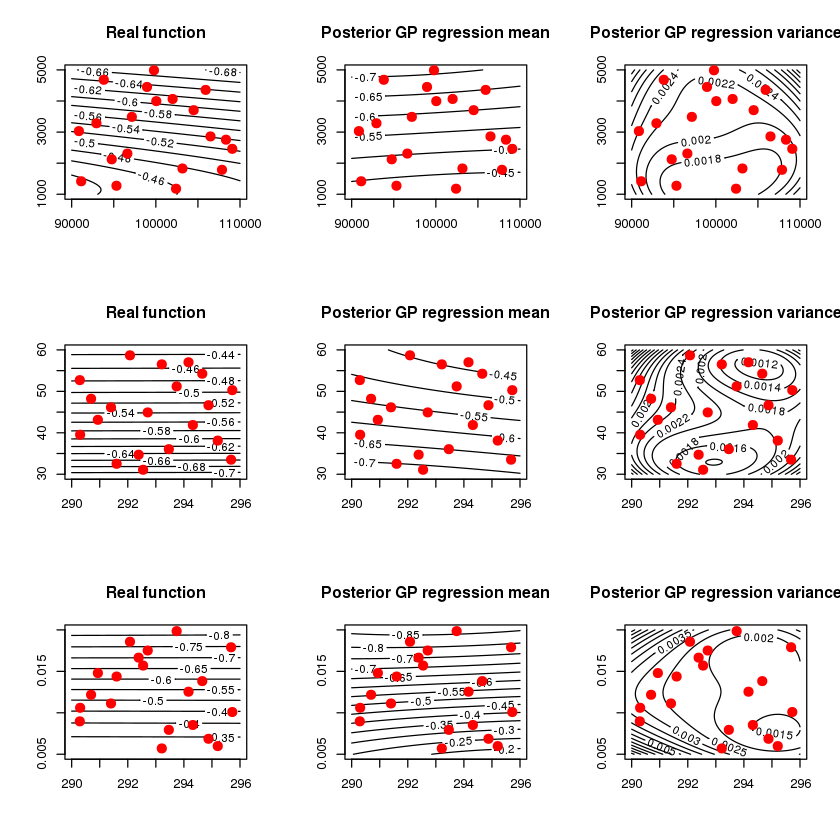

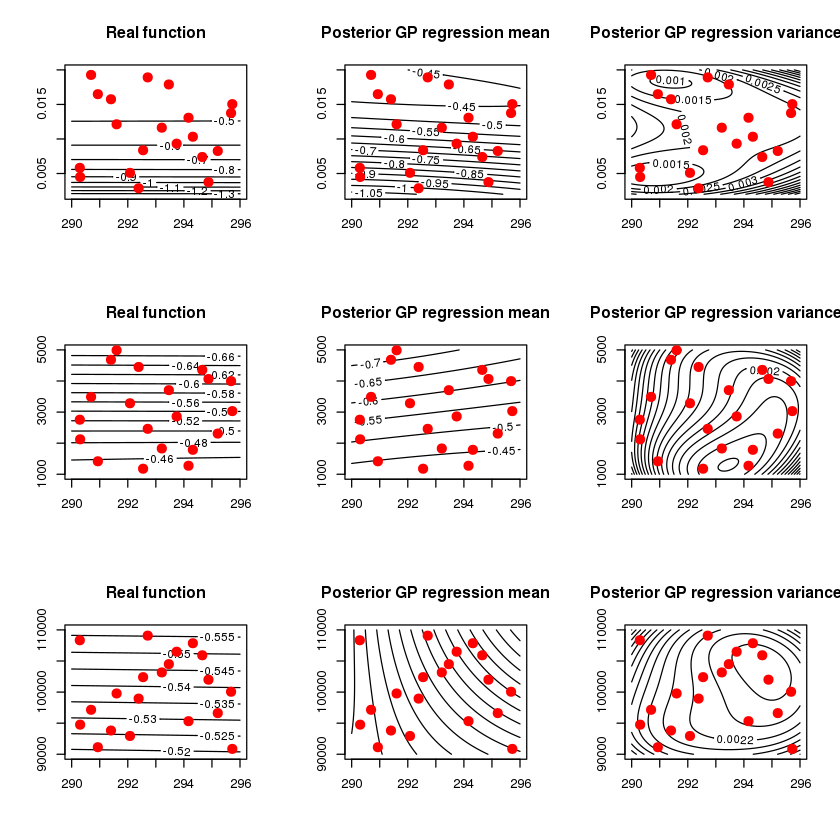

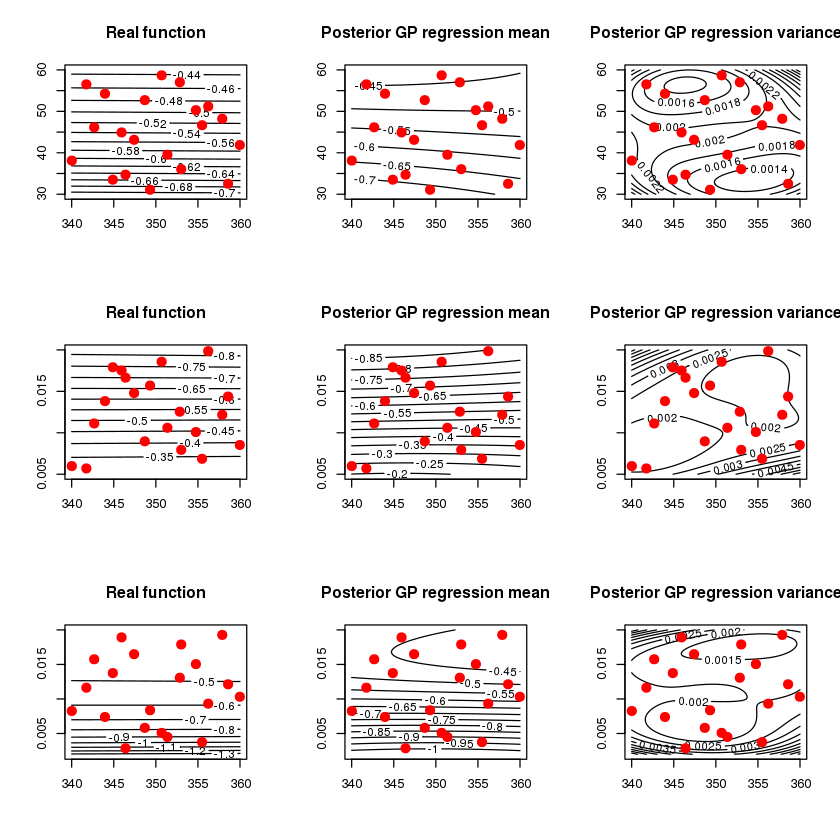

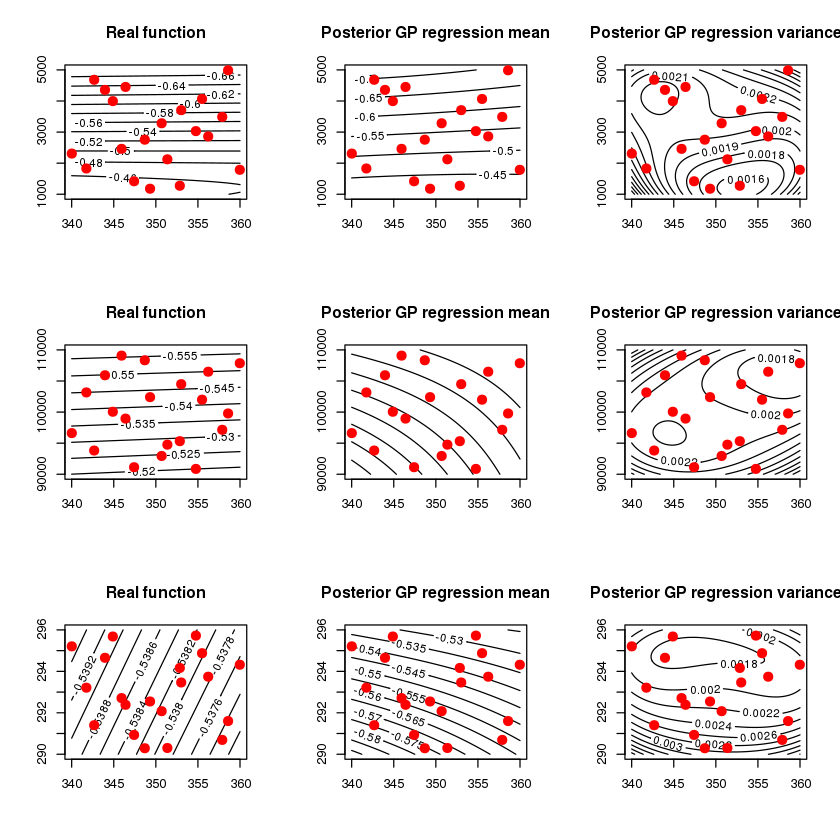

In [121]:
# PLOT THE GPR MEAN AND VARIANCE , AS WELL AS THE REAL FUNCTION

d_input <- length(input_min)

# Contour plot
par(mfrow = c(3,3))
for (i in 1:d_input) 
    for ( j in 1:d_input ) 
        if(i>j) {
            
            # GET THE GRID FOR INPUTS

            n.grid <- 100 ;
            x1.grid <-seq(input_min[i],input_max[i],length.out=n.grid) ;
            x2.grid <-seq(input_min[j],input_max[j],length.out=n.grid) ;
            X.grid <- expand.grid( x1=x1.grid,  x2=x2.grid )
            
            # COMPUTE THE REAL FUNCTION
            
            myfun_2d<-function(xx){ 
                        zz<-0.5*(input_min+input_max) ; 
                        zz[i]<-xx[1]; zz[j]<-xx[2]; 
                        return(myfun(zz)) 
            }
            y.grid <- apply(X.grid, 1, myfun_2d)
            
            contour(x1.grid, x2.grid, matrix(y.grid, n.grid, n.grid), 11, main = "Real function")
            points(X_data[ , i], X_data[ , j], pch = 19, cex = 1.5, col = "red")  
            
            # COMPUTE THE GPR MEAN
            
            myfun_km_pred_2d_mean<-function(xx){ 
                                zz<-0.5*(input_min+input_max) ; 
                                zz[i]<-xx[1]; zz[j]<-xx[2]; 
                                return( predict(myfun_km, t(matrix(zz)), "UK", checkNames=FALSE)$mean ) 
            }
            y.pred.grid_mean <- apply(X.grid, 1, myfun_km_pred_2d_mean)  
            
            contour(x1.grid, x2.grid, matrix(y.pred.grid_mean, n.grid, n.grid), 11, main = "Posterior GP regression mean")
            points(X_data[ , i], X_data[ , j], pch = 19, cex = 1.5, col = "red") 
            
            # COMPUTE THE GPR VARIANCE
            
            myfun_km_pred_2d_sd<-function(xx){ 
                                zz<-0.5*(input_min+input_max) ; 
                                zz[i]<-xx[1]; zz[j]<-xx[2]; 
                                return( predict(myfun_km, t(matrix(zz)), "UK", checkNames=FALSE)$sd ) 
            }
            y.pred.grid_sd <- apply(X.grid, 1, myfun_km_pred_2d_sd)          

            contour(x1.grid, x2.grid, matrix(y.pred.grid_sd^2, n.grid, n.grid), 15, main = "Posterior GP regression variance")
            points(X_data[ , i], X_data[ , j], pch = 19, cex = 1.5, col = "red")

            }